In [3]:
from matplotlib import pyplot as plt
import numpy as np
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, resize, downscale_local_mean
import math
import os
import numpy as np


import sigpy as sp
import sigpy.plot as pl
import seaborn as sns
from cmcrameri import cm

import sys
sys.path.append("/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python")
from mystic_mrpy.Data_Import.Diffusion   import *
from mystic_mrpy.Data_Sorting.Diffusion  import *
from mystic_mrpy.Diffusion.DWI  import *
from mystic_mrpy.Diffusion.Gibbs         import *
from mystic_mrpy.Diffusion.Registration  import *
from mystic_mrpy.Diffusion.Rejection     import *
from mystic_mrpy.Diffusion.Respiratory   import *
from mystic_mrpy.Diffusion.Averaging     import *
from mystic_mrpy.Diffusion.Denoising     import *
from mystic_mrpy.Diffusion.Interpolation import *
from mystic_mrpy.Diffusion.Segmentation_Matrix_DTI import *
from mystic_mrpy.Diffusion.DTI import *
from mystic_mrpy.Diffusion.cDTI import *

import numpy as np
import matplotlib.pyplot as plt

In [4]:
from PIL import Image, ImageFilter
def get_edge(img):
    #define the vertical filter
    vertical_filter = [[-1,-2,-1], [0,0,0], [1,2,1]]

    #define the horizontal filter
    horizontal_filter = [[-1,0,1], [-2,0,2], [-1,0,1]]

    #get the dimensions of the image
    n,m = img.shape

    #initialize the edges image
    edges_img = img.copy()

    #loop over all pixels in the image
    for row in range(3, n-2):
        for col in range(3, m-2):

            #create little local 3x3 box
            local_pixels = img[row-1:row+2, col-1:col+2]

            #apply the vertical filter
            vertical_transformed_pixels = vertical_filter*local_pixels
            #remap the vertical score
            vertical_score = vertical_transformed_pixels.sum()/4

            #apply the horizontal filter
            horizontal_transformed_pixels = horizontal_filter*local_pixels
            #remap the horizontal score
            horizontal_score = horizontal_transformed_pixels.sum()/4

            #combine the horizontal and vertical scores into a total edge score
            edge_score = (vertical_score**2 + horizontal_score**2)**.5

            #insert this edge score into the edges image
            edges_img[row, col] = edge_score*2

    #remap the values in the 0-1 range in case they went out of bounds
    edges_img = edges_img/edges_img.max()
    edges_img[edges_img ==0] = 'nan'
    edges_img[edges_img > 0] = 1
    return edges_img

In [5]:
from dipy.segment.mask import median_otsu
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import numpy as np

allsubj = np.zeros((128,128,6,4,5,2,1),dtype = 'complex')
mask_all = np.zeros((128,128,6,2,1)) #X, Y, Volunteer #, Slice #

cut = 20
filt = np.concatenate((np.zeros((cut,100-cut*2)),np.ones((128-cut*2,100-cut*2)),np.zeros((cut,100-cut*2))))
filt = np.concatenate((np.zeros((128,cut)),filt,np.zeros(((128,cut)))),axis = -1)

M0_mag = np.zeros((128,100,3,4,5,10))
M1_mag = np.zeros((128,100,3,4,5,10))
M2_mag = np.zeros((128,100,3,4,5,10))

M0_phs = np.zeros((128,100,3,4,5,10))
M1_phs = np.zeros((128,100,3,4,5,10))
M2_phs = np.zeros((128,100,3,4,5,10))

M0_mask = np.zeros((128,100,3,4,5,10))
M1_mask = np.zeros((128,100,3,4,5,10))
M2_mask = np.zeros((128,100,3,4,5,10))

M0_adc_avg = np.zeros((128,100,3,10))
M1_adc_avg = np.zeros((128,100,3,10))
M2_adc_avg = np.zeros((128,100,3,10))



count = 0
for vv in range(1,11):
    print(vv)
    volunteer = str(vv)
    # inpath = '/Volumes/T7/phase_paper/Heart/V00' + volunteer + '/DWI'
    inpath = '/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Projects/Phase/Data/Heart/V00' + volunteer + '/DWI'

    name = inpath.split('/')
    namejoin = '/'.join(name[:-1])
    
    nii_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.nii')]
    bval_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvals')]
    bvec_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvecs')]
    nii_files.sort()
    bval_files.sort()
    bvec_files.sort()

    #print(nii_files)

    
    mask_files_LV = [_ for _ in os.listdir(inpath) if _.startswith('LV')]
    mask_files_BP = [_ for _ in os.listdir(inpath) if _.startswith('BP')]
    
    mask_files_LV.sort()
    mask_files_BP.sort()

    mm = 0
    for num in range(1,7,2):
    
    # inpath = '/Volumes/T7/phase_paper/Heart/V00' + volunteer + '/DWI'
        data,affine, voxsize = load_nifti(os.path.join(inpath, nii_files[num]), return_voxsize=True)
        bvals = np.loadtxt(os.path.join(inpath,bval_files[num])) 
        bvecs = np.loadtxt(os.path.join(inpath,bvec_files[num]))
        
        mask_LV,affine, voxsize = load_nifti(os.path.join(inpath, mask_files_LV[mm]), return_voxsize=True)
        mask_BP,affine, voxsize = load_nifti(os.path.join(inpath, mask_files_BP[mm]), return_voxsize=True)
    
        data1,bvals_sort,bvecs_sort = stacked2sorted(data,bvals,bvecs.T)

        ims = data1
        mag = abs(ims)
        phs = np.angle(ims)
        
        mask_LV_rep = np.tile(mask_LV[:,:,:,np.newaxis,np.newaxis],(1,1,1,4,5))
        mask_BP_rep = np.tile(mask_BP[:,:,:,np.newaxis,np.newaxis],(1,1,1,4,5))
        mask_rep = (mask_LV_rep - mask_BP_rep).astype(np.float32)
        
        mask_rep[mask_rep ==0] = np.nan
        adc_avg = DWI_recon(mag,bvals_sort,bvecs_sort)
        
        
        im = mag * np.exp(1j*phs)
       
        
        if mag.shape[0] == 100:
            print('Dim',vv)
            mag = mag.transpose(1,0,2,3,4)
            phs = phs.transpose(1,0,2,3,4)
            mask_rep = mask_rep.transpose(1,0,2,3,4)
            adc_avg[0]['ADC'] = adc_avg[0]['ADC'].transpose(1,0,2)

        
        if num == 1:
            M0_mag[:,:,:,:,:,count] = mag #* mask_rep
            M0_phs[:,:,:,:,:,count] = phs #*mask_rep
            M0_mask[:,:,:,:,:,count] = mask_rep #*mask_rep
            M0_adc_avg[:,:,:,count] = adc_avg[0]['ADC']

            
            
            
        if num == 3:
            M1_mag[:,:,:,:,:,count] = mag #* mask_rep
            M1_phs[:,:,:,:,:,count] = phs #*mask_rep
            M1_mask[:,:,:,:,:,count] = mask_rep #*mask_rep
            M1_adc_avg[:,:,:,count] = adc_avg[0]['ADC']

        if num == 5:
            M2_mag[:,:,:,:,:,count] = mag #* mask_rep
            M2_phs[:,:,:,:,:,count] = phs #*mask_rep
            M2_mask[:,:,:,:,:,count] = mask_rep #*mask_rep
            M2_adc_avg[:,:,:,count] = adc_avg[0]['ADC']
           
        mm = mm +1
    count = count + 1

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


1


/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python/mystic_mrpy/Diffusion/DWI.py:45: RuntimeWarning: divide by zero encountered in divide
  D_xx                             = -(1 / b) * np.log(S_x / S_0)                                                             # Calculate x diffusion coefficient
/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python/mystic_mrpy/Diffusion/DWI.py:45: RuntimeWarning: invalid value encountered in divide
  D_xx                             = -(1 / b) * np.log(S_x / S_0)                                                             # Calculate x diffusion coefficient
/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python/mystic_mrpy/Diffusion/DWI.py:45: RuntimeWarning: divide by zero encountered in log
  D_xx                             = -(1 / b) * np.log(S_x / S_0)                                                             # Calculate x diffusion coefficient
/Users/arielhannum/Documents/Stanford/CMR-Setsompop/C

2
Dim 2
Dim 2
Dim 2
3
4
5
Dim 5
Dim 5
Dim 5
6
7
8
9
10
Dim 10
Dim 10
Dim 10


In [6]:
nii_files

['M0_mag_registered.nii',
 'M0_registered.nii',
 'M1_mag_registered.nii',
 'M1_registered.nii',
 'M2_mag_registered.nii',
 'M2_registered.nii']

In [7]:

M0_adj = (np.exp(1j*M0_phs)) / np.nanmean(np.exp(1j*M0_phs[:,:,:,0,:,:]),axis = -2)[:,:,:,np.newaxis,np.newaxis,:]
M1_adj = (np.exp(1j*M1_phs)) / np.nanmean(np.exp(1j*M1_phs[:,:,:,0,:,:]),axis = -2)[:,:,:,np.newaxis,np.newaxis,:]
M2_adj = (np.exp(1j*M2_phs)) / np.nanmean(np.exp(1j*M2_phs[:,:,:,0,:,:]),axis = -2)[:,:,:,np.newaxis,np.newaxis,:]
print(M0_adj.shape)

M0_diff = np.angle(M0_adj / np.tile(np.nanmean(M0_adj,axis = -2)[:,:,:,:,np.newaxis,:],(1,1,1,1,5,1)))
M1_diff = np.angle(M1_adj / np.tile(np.nanmean(M1_adj,axis = -2)[:,:,:,:,np.newaxis,:],(1,1,1,1,5,1)))
M2_diff = np.angle(M2_adj / np.tile(np.nanmean(M2_adj,axis = -2)[:,:,:,:,np.newaxis,:],(1,1,1,1,5,1)))
print(M0_diff.shape)

phs_diff_all = np.stack((np.angle(M0_diff),np.angle(M1_diff),np.angle(M2_diff)))
print(phs_diff_all.shape)

num_M0 =  M0_diff * (M0_adj * np.tile(np.nanmean(M0_adj,axis = -2)[:,:,:,:,np.newaxis,:],(1,1,1,1,5,1)))

M0_std = np.sqrt(np.sum(M0_diff**2,axis = -2)/5)
M1_std = np.sqrt(np.sum(M1_diff**2,axis = -2)/5)
M2_std = np.sqrt(np.sum(M2_diff**2,axis = -2)/5)

(128, 100, 3, 4, 5, 10)
(128, 100, 3, 4, 5, 10)
(3, 128, 100, 3, 4, 5, 10)


In [8]:
diffusion = -1 # diffusion direction [0, X [1], Y[2], Z[3]]
sl = 1 #slice [Base [0], Mid[0], Apex[2]]
rep = 3
vv = 5

TD 5 Volunteer 5 sl 1


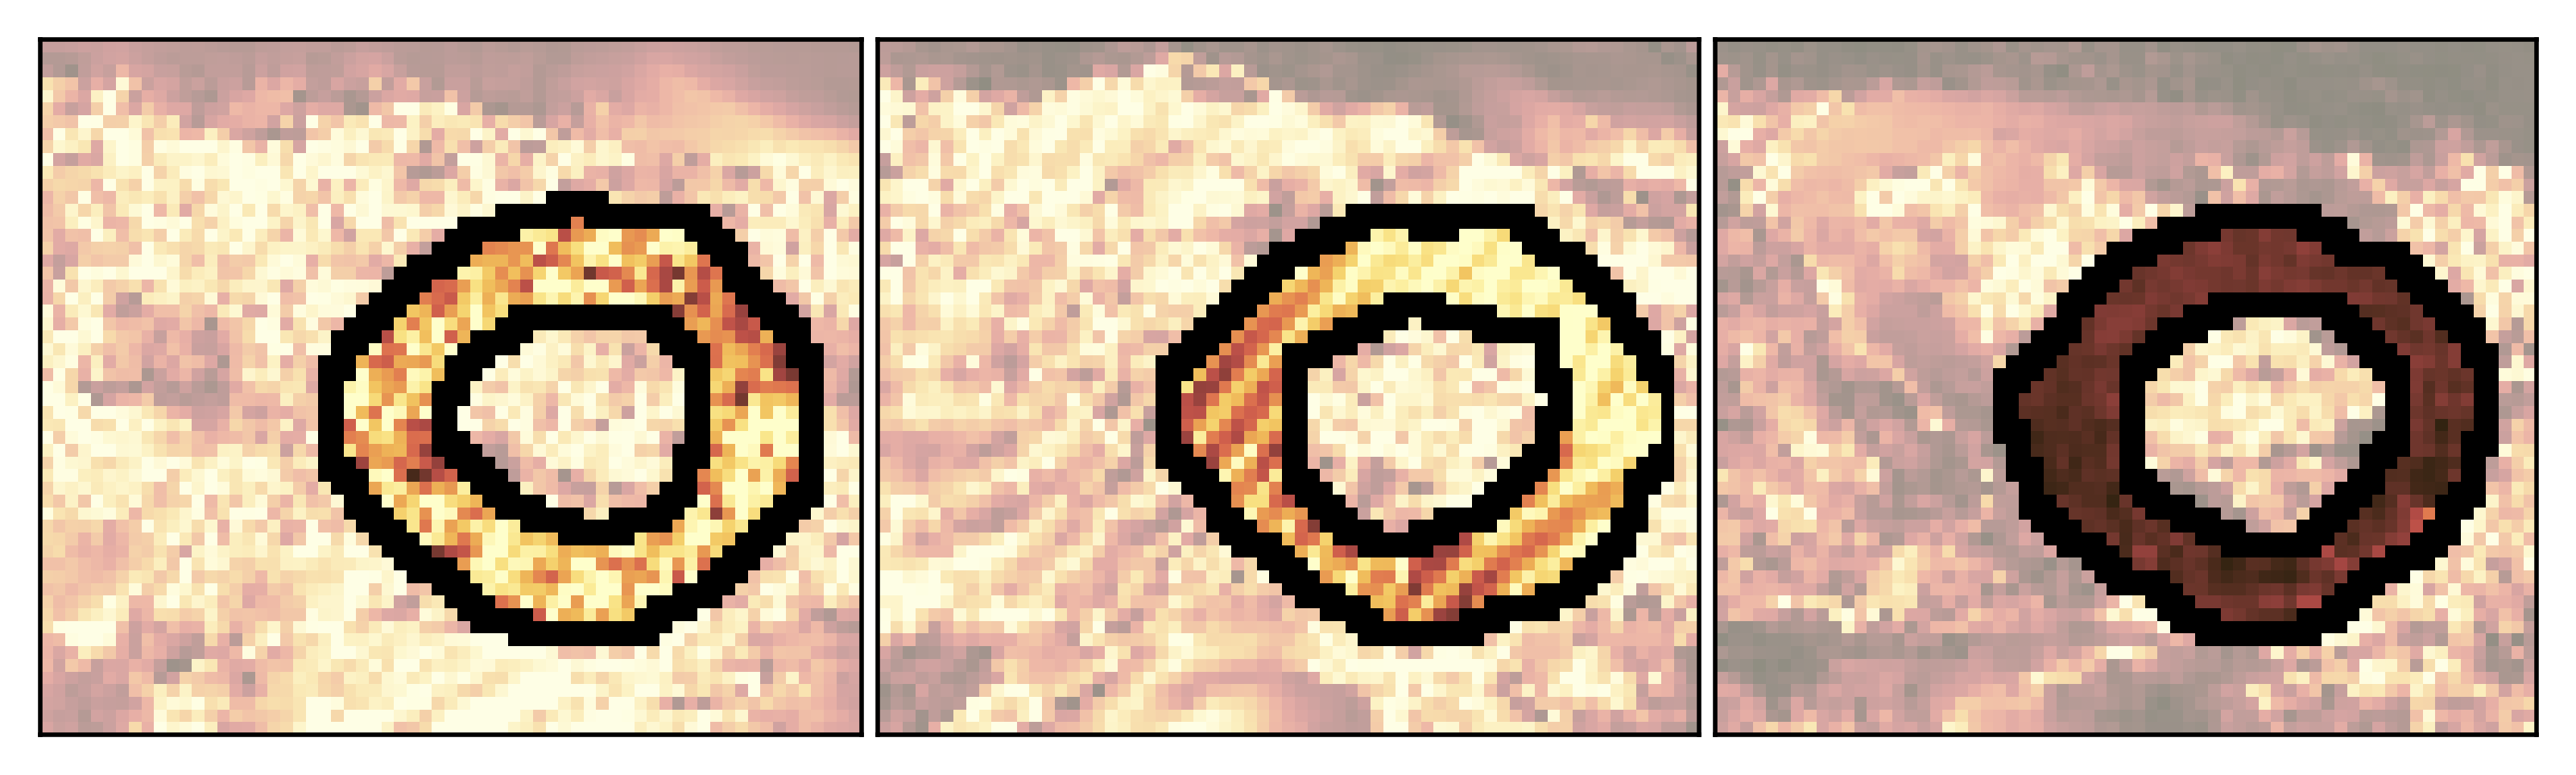

In [19]:
# Horizontal Fig 
td = vv

print('TD',td, 'Volunteer',vv,'sl',sl)
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(8,6), dpi=500)

w1 = 20
w2 = 75
l1= 10
l2 = 75


color = cm.lajolla_r
######### STandard Deviation 
phs_m0 = (M0_std) #* M0_mask[:,:,:,diffusion,0,:]
phs_m1 = (M1_std) #* M1_mask[:,:,:,diffusion,0,:]
phs_m2 = (M2_std) #* M2_mask[:,:,:,diffusion,0,:] 
axes[0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,td],vmin = 0,vmax = math.pi/2,cmap = color,alpha = 0.5,interpolation = 'nearest')
axes[1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,td,],vmin = 0,vmax = math.pi/2,cmap = color,alpha = 0.5,interpolation = 'nearest')
im2=axes[2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,td],vmin = 0,vmax = math.pi/2,cmap = color,alpha = 0.5,interpolation = 'nearest')

phs_m0 = (M0_std[:,:,:,:,np.newaxis,:]) * M0_mask
phs_m1 = (M1_std[:,:,:,:,np.newaxis,:]) * M1_mask
phs_m2 = (M2_std[:,:,:,:,np.newaxis,:]) * M2_mask
axes[0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
axes[1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
im4=axes[2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
axes[0].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[1].imshow(get_edge(np.nan_to_num(M1_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[2].imshow(get_edge(np.nan_to_num(M2_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')



for j in range(3):
    axes[j].get_xaxis().set_ticks([])
    axes[j].get_yaxis().set_ticks([])

plt.subplots_adjust(wspace=0.02, hspace=0.01)   
plt.show()

TD 5 Volunteer 5 sl 1


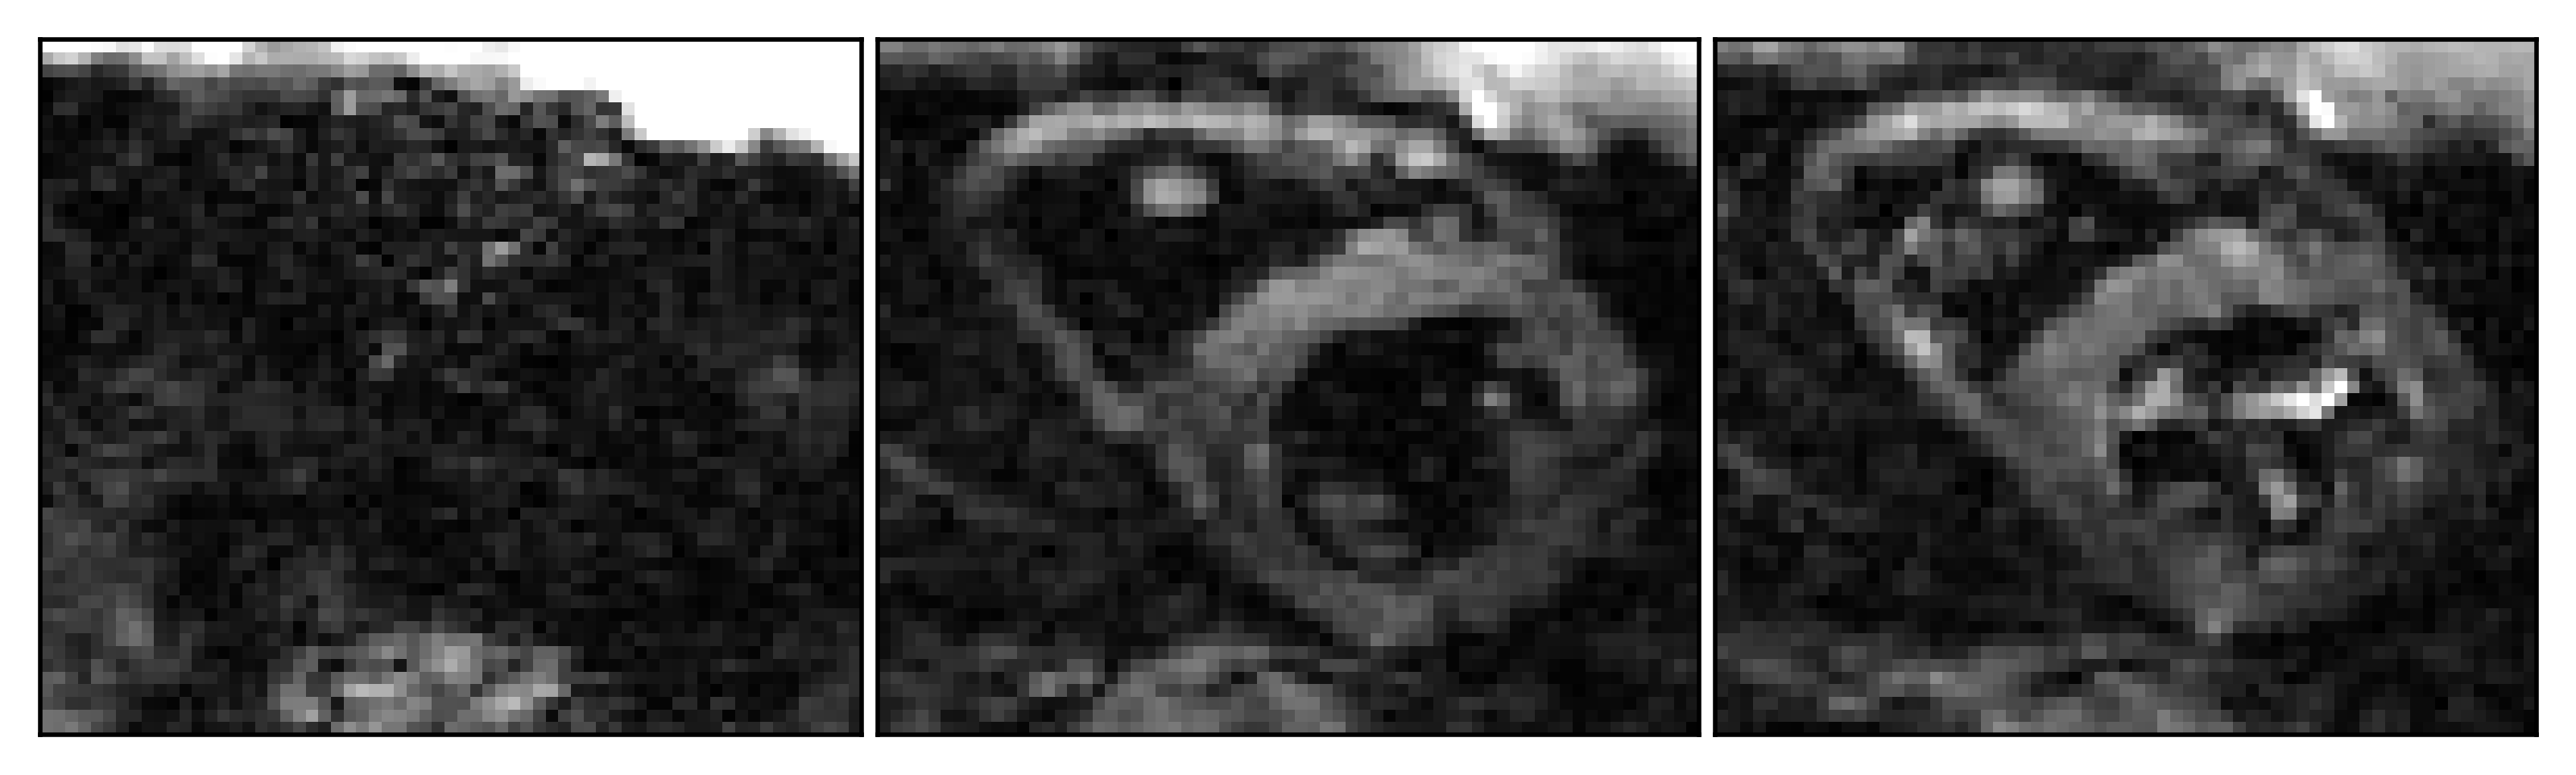

In [18]:
# Horizontal Fig 
td = vv

print('TD',td, 'Volunteer',vv,'sl',sl)
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(8,6), dpi=500)

w1 = 20
w2 = 75
l1= 10
l2 = 75

color = 'gray'
vmax = 100

phs_m0 = (M0_mag[:,:,:,:,:]) 
phs_m1 = (M1_mag[:,:,:,:,:]) 
phs_m2 = (M2_mag[:,:,:,:,:]) 
axes[0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,0,vv],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
axes[1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,0,vv],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
im4=axes[2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,0,vv],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
#axes[0].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,diffusion,0,vv])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
#axes[1].imshow(get_edge(np.nan_to_num(M1_mask[w1:w2,l1:l2,sl,diffusion,0,vv])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
#axes[2].imshow(get_edge(np.nan_to_num(M2_mask[w1:w2,l1:l2,sl,diffusion,0,vv])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')



for j in range(3):
    axes[j].get_xaxis().set_ticks([])
    axes[j].get_yaxis().set_ticks([])

plt.subplots_adjust(wspace=0.02, hspace=0.01)   
plt.show()

In [13]:
M2_mag.shape

(128, 100, 3, 4, 5, 10)